In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

path = '/content/gdrive/My Drive/activity-classification'

import sys
sys.path.append(path)

Mounted at /content/gdrive/


# Imports

In [ ]:
# General
import pandas as pd
import numpy as np
from sklearn import preprocessing


# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# ML
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, precision_score, accuracy_score, roc_curve
from scipy.fft import fft, ifft
from sklearn.utils import shuffle
from sklearn.svm import SVC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import callbacks

# My functions
#from my_functions import xyz_plot, multi_index

# Settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)

# Read data

In [ ]:
df = pd.read_pickle(str(path + '/my-data/df_original.pkl'))

# Functions

In [ ]:
def to_activity_name(data):
  activities_dict = {1:'sitting', 
                   2:'standing',
                   3:'lying_back',
                   4:'lying_right_side',
                   5:'ascend_stairs',
                   6:'descend_stairs',
                   7:'standing_elevator',
                   8:'moving_elevator',
                   9:'walking_outside',
                   10:'walking_treadmill_flat',
                   11:'walking_treadmill_incline',
                   12:'running_treadmill_flat',
                   13:'exercising_stepper',
                   14:'exercising_crosstrainer',
                   15:'cycling_horizontal',
                   16:'cycling_vertical',
                   17:'rowing',
                   18:'jumping',
                   19:'basketball'}
  data['activity'] = (data['activity']+1).replace(activities_dict)
  return data

def to_activity_code(data):
  activities_dict = {1:'sitting', 
                   2:'standing',
                   3:'lying_back',
                   4:'lying_right_side',
                   5:'ascend_stairs',
                   6:'descend_stairs',
                   7:'standing_elevator',
                   8:'moving_elevator',
                   9:'walking_outside',
                   10:'walking_treadmill_flat',
                   11:'walking_treadmill_incline',
                   12:'running_treadmill_flat',
                   13:'exercising_stepper',
                   14:'exercising_crosstrainer',
                   15:'cycling_horizontal',
                   16:'cycling_vertical',
                   17:'rowing',
                   18:'jumping',
                   19:'basketball'}
  inv_activities_dict = {v: k for k, v in activities_dict.items()}
  data['activity'] = (data['activity']).replace(inv_activities_dict)-1
  return data

In [ ]:
sensor_positions = ['t', 'rl', 'll', 'ra', 'la']

In [ ]:
def xyz_plot(df, sensor, position, activities, person, interval=(0,5)):
  for activity in activities: 
    sensors = [f'{position}_{i}{sensor}' for i in ['x','y','z']]
    subset = df.query(f"person=='{person}' & activity=='{activity}' & seconds >= {interval[0]} & seconds <= {interval[1]}")
    plt.figure(figsize=(20,3))
    for j in sensors:
      sns.lineplot(subset.seconds, subset[f'{j}'], label=f'{j}', legend='full').set(xlabel='Seconds', ylabel='', 
                                                                                    title=f'Person {person} {activity.replace("_", " ").title()}')

# Explore data

Plot data, work out good window size and decide if any variables are duds

In [ ]:
df.head()

,activity,person,seconds,t_xacc,t_yacc,t_zacc,t_xgyro,t_ygyro,t_zgyro,t_xmag,t_ymag,t_zmag,ra_xacc,ra_yacc,ra_zacc,ra_xgyro,ra_ygyro,ra_zgyro,ra_xmag,ra_ymag,ra_zmag,la_xacc,la_yacc,la_zacc,la_xgyro,la_ygyro,la_zgyro,la_xmag,la_ymag,la_zmag,rl_xacc,rl_yacc,rl_zacc,rl_xgyro,rl_ygyro,rl_zgyro,rl_xmag,rl_ymag,rl_zmag,ll_xacc,ll_yacc,ll_zacc,ll_xgyro,ll_ygyro,ll_zgyro,ll_xmag,ll_ymag,ll_zmag
0,0,1,0.00,8.1305,1.0349,5.4217,-0.009461,0.001915,-0.003424,-0.78712,-0.069654,0.15730,0.70097,5.6829,7.9812,0.003876,-0.005213,-0.001168,-0.57285,-0.55907,-0.21226,3.4193,-8.3416,3.8627,-0.005155,-0.008437,-0.015600,-0.64769,0.34136,0.073549,-3.5160,9.0513,-0.93283,0.004734,0.007949,-0.013605,0.72985,-0.25366,-0.036453,-2.8071,-9.0812,2.6220,-0.000232,-0.012092,-0.004457,0.74017,0.30053,-0.057730
1,0,1,0.04,8.1305,1.0202,5.3843,-0.009368,0.023485,0.001953,-0.78717,-0.068275,0.15890,0.71829,5.6005,7.9712,0.012862,-0.005241,-0.003029,-0.57306,-0.55684,-0.21335,3.4340,-8.3708,3.8537,-0.014302,-0.001877,-0.004997,-0.64838,0.34240,0.074865,-3.5386,9.0812,-0.93332,0.014458,0.002668,-0.011870,0.73172,-0.25236,-0.034005,-2.8146,-9.0737,2.6218,-0.014784,-0.016477,0.002789,0.73937,0.30183,-0.057514
2,0,1,0.08,8.1604,1.0201,5.3622,0.015046,0.014330,0.000204,-0.78664,-0.068277,0.15879,0.69849,5.6612,7.9568,0.021639,-0.010421,0.011992,-0.57357,-0.55788,-0.21336,3.4291,-8.3757,3.8757,0.000126,-0.008308,-0.012062,-0.64821,0.34099,0.073155,-3.5385,9.0662,-0.92580,-0.009606,0.010623,-0.008289,0.72914,-0.25249,-0.036489,-2.8221,-9.0886,2.6366,-0.012770,0.005717,-0.007918,0.73955,0.30052,-0.057219
3,0,1,0.12,8.1603,1.0052,5.3770,0.006892,0.018045,0.005649,-0.78529,-0.069849,0.15912,0.72799,5.6393,7.9763,0.016440,0.001875,0.002322,-0.60463,-0.56833,-0.24523,3.4437,-8.3271,3.8286,0.000092,0.003542,-0.011145,-0.64841,0.34125,0.074143,-3.5385,9.0587,-0.94080,0.000949,0.007971,-0.003015,0.73080,-0.25176,-0.036151,-2.8071,-9.0811,2.6070,-0.005725,0.009620,0.006555,0.74029,0.30184,-0.057750
4,0,1,0.16,8.1605,1.0275,5.3473,0.008811,0.030433,-0.005346,-0.78742,-0.068796,0.15916,0.71572,5.6441,7.9714,0.000286,-0.003408,0.002425,-0.56864,-0.55990,-0.21383,3.4486,-8.3709,3.8466,-0.012524,0.003591,-0.004980,-0.64909,0.34152,0.075607,-3.5311,9.0812,-0.93317,-0.009898,-0.002577,0.003975,0.73035,-0.25235,-0.033807,-2.8146,-9.0737,2.6218,-0.003929,-0.008371,0.002816,0.73845,0.30090,-0.057527


In [ ]:
# check that the data is well balanced across activities
df['activity'].value_counts()

18    60000
10    60000
1     60000
2     60000
3     60000
6     60000
7     60000
8     60000
9     60000
11    60000
12    60000
13    60000
14    60000
15    60000
16    60000
0     60000
17    59050
5     57000
4     57000
Name: activity, dtype: int64

In [ ]:
# check that the data is well balanced across idividuals
df['person'].value_counts()

7    142500
8    142500
4    142500
2    142500
3    142500
5    142500
1    139500
6    138550
Name: person, dtype: int64

# Scale and partition
Choose data from multiple parts of the time interval to help ensure distributions match 

In [ ]:
#seconds = df.query('activity == 1 & person == "1"')['seconds']

#test = df.query('(seconds < 30) | (seconds >= 150 & seconds < 180) | (seconds >=270)')
#train = df.query('(seconds >= 30 & seconds < 150) | (seconds >= 180 & seconds < 270) | (seconds >=300)')


test = df.query('(seconds < 180)')
val = df.query('(seconds >= 180 & seconds < 220)')
train = df.query('(seconds >= 220 & seconds < 300)')


In [ ]:
# scale the data
scaler = StandardScaler()
scaler.fit(train.iloc[:, 3:48])
train.iloc[:, 3:48] = scaler.transform(train.iloc[:, 3:48])
test.iloc[:, 3:48] = scaler.transform(test.iloc[:, 3:48])
val.iloc[:, 3:48] = scaler.transform(val.iloc[:, 3:48])

In [ ]:
# checkpoint
test.to_pickle(str(path+'/my-data/test.pkl'))
train.to_pickle(str(path+'/my-data/train.pkl'))
val.to_pickle(str(path+'/my-data/val.pkl'))

In [ ]:
val

,activity,person,seconds,t_xacc,t_yacc,t_zacc,t_xgyro,t_ygyro,t_zgyro,t_xmag,t_ymag,t_zmag,ra_xacc,ra_yacc,ra_zacc,ra_xgyro,ra_ygyro,ra_zgyro,ra_xmag,ra_ymag,ra_zmag,la_xacc,la_yacc,la_zacc,la_xgyro,la_ygyro,la_zgyro,la_xmag,la_ymag,la_zmag,rl_xacc,rl_yacc,rl_zacc,rl_xgyro,rl_ygyro,rl_zgyro,rl_xmag,rl_ymag,rl_zmag,ll_xacc,ll_yacc,ll_zacc,ll_xgyro,ll_ygyro,ll_zgyro,ll_xmag,ll_ymag,ll_zmag
4500,0,1,180.00,0.020820,0.868420,0.789495,0.005764,-0.008426,-0.037596,-0.518332,-0.450102,1.142230,-0.726442,0.287578,1.158126,-0.018773,0.026461,0.002885,-0.688728,-0.691867,0.205026,-0.177516,-1.003467,-0.023844,0.026059,0.008519,-0.009909,-0.775010,0.000468,0.912460,0.653293,1.038196,0.201163,-0.014537,-0.040230,0.009143,0.813976,0.047302,-0.318702,0.781580,-0.973620,0.926602,0.015219,-0.028740,0.022024,0.728516,0.012708,-0.326639
4501,0,1,180.04,0.033855,0.840789,0.772914,0.045243,0.014414,0.025784,-0.515737,-0.447041,1.141217,-0.727756,0.302465,1.149275,0.007531,0.029761,-0.001554,-0.690631,-0.693621,0.204932,-0.171796,-1.033117,-0.022092,0.007935,0.043450,-0.014380,-0.776497,0.001106,0.915193,0.652052,1.035746,0.201119,-0.019325,-0.050462,0.000070,0.813922,0.053728,-0.317257,0.784141,-0.973636,0.926660,-0.002765,-0.033681,-0.002389,0.726029,0.011300,-0.327448
4502,0,1,180.08,0.023417,0.846471,0.772803,0.004653,-0.003191,-0.005936,-0.521662,-0.450684,1.136949,-0.726036,0.290769,1.155612,-0.012885,-0.002832,0.001018,-0.689363,-0.696836,0.208133,-0.182402,-1.001232,-0.022866,0.015688,0.016999,-0.018029,-0.775583,0.000217,0.911586,0.657068,1.035763,0.201311,-0.016294,-0.045378,0.000085,0.810888,0.050410,-0.318860,0.784141,-0.976110,0.922331,0.013446,-0.058581,0.004382,0.728202,0.012004,-0.326259
4503,0,1,180.12,0.014259,0.841160,0.760200,0.012266,-0.014607,0.008599,-0.518558,-0.445408,1.138509,-0.728589,0.297175,1.146709,0.005616,0.023986,-0.014387,-0.751537,-0.724817,0.134351,-0.170996,-1.016655,-0.031261,0.019092,0.024226,0.001837,-0.775562,0.000491,0.912146,0.653310,1.033313,0.194097,-0.041386,-0.029953,-0.002884,0.813484,0.052780,-0.319107,0.784141,-0.976110,0.926660,0.015752,-0.041097,-0.008550,0.725348,0.012682,-0.326746
4504,0,1,180.16,0.028627,0.846322,0.783236,-0.002993,0.001913,-0.014649,-0.518728,-0.447038,1.142202,-0.725228,0.295054,1.147992,0.008654,0.042115,-0.004078,-0.681369,-0.693807,0.202743,-0.172230,-1.013380,-0.019112,0.024933,0.031823,-0.003554,-0.774032,-0.000147,0.910551,0.647036,1.038180,0.200927,-0.037768,-0.036729,0.010659,0.812938,0.054281,-0.322797,0.780299,-0.978567,0.924365,-0.000781,-0.055300,-0.000917,0.726893,0.008536,-0.325484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131045,18,8,219.80,1.334857,0.073044,1.393651,0.864561,1.189727,0.701633,-0.638197,-0.762981,0.708699,-2.971359,-2.741962,0.392225,-1.600893,-1.071136,-0.705287,2.201829,0.784037,0.508566,-2.090440,3.772050,-4.525227,-0.140802,0.045223,-1.394171,1.435303,-2.365861,0.927285,-2.285628,-0.110448,0.271439,1.139295,0.137058,-1.299214,0.808347,1.731749,-0.148138,-2.158987,0.680801,-1.576793,-0.441060,0.689266,1.373056,0.798217,-1.469343,0.698780
1131046,18,8,219.84,0.984686,-0.501134,1.316087,0.636526,0.964731,0.177213,-0.643333,-0.750819,0.643632,-2.019661,-2.530912,0.584289,1.249832,0.624049,-0.686650,2.202484,0.847258,0.492746,-2.748504,4.988059,-7.297950,-1.442393,-2.036585,-2.321072,1.559982,-2.302734,0.854828,-1.575480,0.237322,0.462527,0.168146,0.521351,-0.957360,0.789574,1.828560,-0.148182,-1.693368,0.474902,-0.756971,1.136059,1.640477,1.922187,0.713487,-1.613385,0.749768
1131047,18,8,219.88,-0.034232,0.412969,0.307779,1.711959,1.926435,-3.905561,-0.628519,-0.801436,0.567960,-0.839721,-0.902220,-0.877675,1.101332,2.186314,-1.745671,2.244802,0.962274,0.564588,-3.051838,3.402166,-5.497625,-2.882699,-6.220710,-4.475336,1.710429,-2.209843,0.567460,-0.084470,-0.182298,0.609154,-0.580038,0.275

# Select features

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

feature_selection = fit_models()
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(feature_selection.X_train, feature_selection.y_train)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(feature_selection.X_train)
X_new.shape

X_train: (15863, 50, 45), X_test: (6798, 50, 45), y_train: (15863, 1), y_test: (6798, 1)


KeyboardInterrupt: ignored

In [ ]:
X_new

array([[-0.53901368, -0.38795206,  1.10389423, ...,  0.73637784,
         0.01113962, -0.34734866],
       [-0.53884417, -0.38670781,  1.09992933, ...,  0.7395336 ,
         0.01837188, -0.34552947],
       [-0.53830767, -0.38434198,  1.09633958, ...,  0.73774529,
         0.01634271, -0.35185897],
       ...,
       [ 0.03120947, -0.7160399 , -0.9183569 , ...,  0.06141866,
         1.15251458,  0.38006613],
       [ 0.12014612, -0.68665689, -0.99468094, ...,  0.03575204,
         1.12288308,  0.49095121],
       [ 0.19772922, -0.67917979, -1.04493856, ...,  0.06354877,
         1.13014126,  0.37615389]])

# Model class

In [ ]:
class FitModels():
  def __init__(self, subset_string='$'):
    drop_vars = ['activity', 'seconds', 'person']
    self.subset_string = subset_string
    self.train = pd.read_pickle((str(path+'/my-data/train.pkl')))
    self.test = pd.read_pickle((str(path+'/my-data/test.pkl')))
    self.val = pd.read_pickle((str(path+'/my-data/val.pkl')))
    self.X_train = self.train.drop(drop_vars, axis=1).filter(regex=f'{subset_string}', axis=1).to_numpy()
    self.X_val = self.val.drop(drop_vars, axis=1).filter(regex=f'{subset_string}', axis=1).to_numpy()
    self.X_test = self.test.drop(drop_vars, axis=1).filter(regex=f'{subset_string}', axis=1).to_numpy()
    self.y_train = self.train['activity'].to_numpy()
    self.y_test = self.test['activity'].to_numpy()
    self.y_val = self.val['activity'].to_numpy()
    self._create_windows()
    self._shuffle()
    self.print_window_shapes()

  def _create_windows(self):
    n_window = 50 
    n_input = self.X_train.shape[1]
    self.X_train_window = self.X_train.reshape(-1, n_window, n_input)
    self.X_val_window = self.X_val.reshape(-1, n_window, n_input)
    self.X_test_window = self.X_test.reshape(-1, n_window, n_input)
    self.y_train_window = self.y_train[::n_window].reshape(-1, 1)
    self.y_val_window = self.y_val[::n_window].reshape(-1, 1)
    self.y_test_window = self.y_test[::n_window].reshape(-1, 1)

  def _shuffle(self):
    self.X_train_window, self.y_train_window = shuffle(self.X_train_window, self.y_train_window)
    self.X_test_window, self.y_test_window = shuffle(self.X_test_window, self.y_test_window)

  def print_window_shapes(self):
    print(f'X_train: {self.X_train_window.shape}, X_test: {self.X_test_window.shape}, y_train: {self.y_train_window.shape}, y_test: {self.y_test_window.shape}')

  def print_array_shapes(self):
    print(f'X_train: {self.X_train.shape}, X_test: {self.X_test.shape}, y_train: {self.y_train.shape}, y_test: {self.y_test.shape}')
  
  def plot_accuracy(self):
    plt.plot(self.lstm_history.history['accuracy'])
    plt.plot(self.lstm_history.history['val_accuracy'])
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

  def plot_loss(self):
    plt.plot(self.lstm_history.history['loss'])
    plt.plot(self.lstm_history.history['val_loss'])
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
  def plot_confusion(self):
    self.predictions = self.lstm.predict_classes(self.X_test_window)
    pred_matrix = confusion_matrix(y_true=self.y_test_window, y_pred=self.predictions).astype('int')
    sns.heatmap(pred_matrix, cmap='YlGnBu')
    
  def run_lstm(self, repeats=1):
    self.test_accuracy = []
    self.test_mse = []
    for i in range(0,repeats):
      print(f'Training model number: {i}')
      self.mc = ModelCheckpoint('best_model.h5', 
                                monitor='val_loss', 
                                mode='min', 
                                verbose=0, 
                                save_best_only=True)
      self.es = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              min_delta=0.1, 
                              patience=50, 
                              verbose=0)
      self.cb_list = [self.mc, self.es]
      self.lstm = Sequential()
      self.lstm.add(LSTM(self.X_train_window[0].shape[1]+1, input_shape=(self.X_train_window[0].shape)))
      self.lstm.add(Dense(19, activation='softmax'))
      self.lstm.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy', 'mse'])
      self.lstm_history = self.lstm.fit(self.X_train_window, self.y_train_window, 
                                        epochs=1000, 
                                        validation_data=(self.X_val_window, self.y_val_window), 
                                        callbacks=self.cb_list, 
                                        verbose=0)
      self.lstm = load_model('best_model.h5')
      self.lstm.save(str(path + f'/my-data/models/lstm-{self.subset_string}/model_{i}'))
      self.plot_loss()
      self.plot_accuracy()
      self.test_accuracy.append(self.lstm.evaluate(self.X_test_window, self.y_test_window)[1])
      self.test_mse.append(self.lstm.evaluate(self.X_test_window, self.y_test_window)[1])

    print('Average accuracy: ' + str(np.mean(self.test_accuracy)) + 
          'Standard Deviation ' + str(np.sd(self.test_mse)) + 
          '/n Accuracy by model: ' + str(self.test_accuracy)
          )

# LSTM

## All sensors

X_train: (6040, 50, 45), X_test: (13601, 50, 45), y_train: (6040, 1), y_test: (13601, 1)
Taining model number: 0


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-$/model_0/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-$/model_0/assets


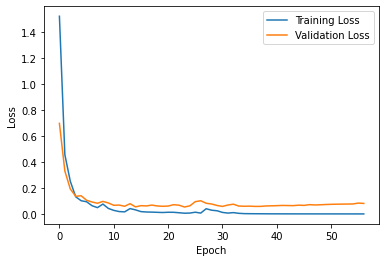

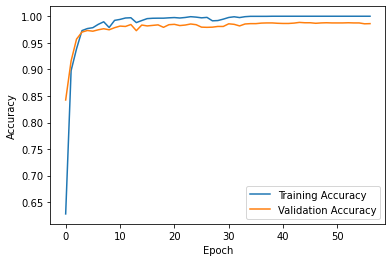

426/426 [==============================] - 1s 3ms/step - loss: 0.2830 - accuracy: 0.9465 - mse: 110.4894
Taining model number: 1


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-$/model_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-$/model_1/assets


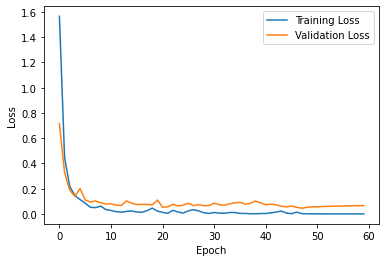

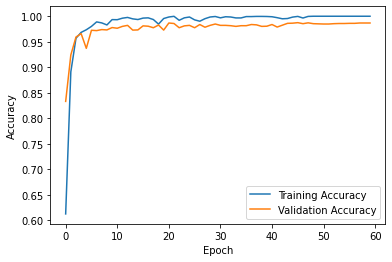

426/426 [==============================] - 1s 3ms/step - loss: 0.2126 - accuracy: 0.9481 - mse: 110.4892
Taining model number: 2


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-$/model_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-$/model_2/assets


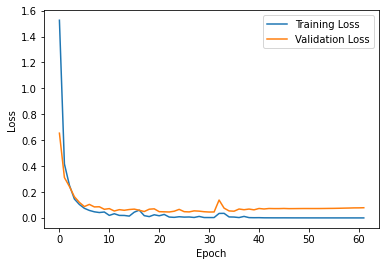

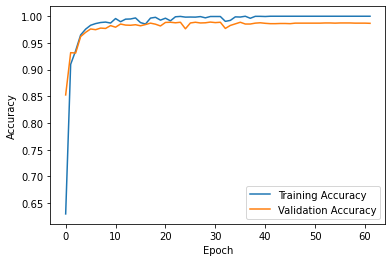

426/426 [==============================] - 1s 3ms/step - loss: 0.1892 - accuracy: 0.9602 - mse: 110.4895
Taining model number: 3


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-$/model_3/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-$/model_3/assets


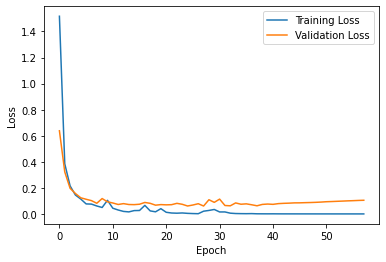

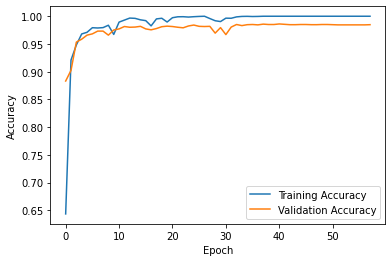

426/426 [==============================] - 1s 3ms/step - loss: 0.1828 - accuracy: 0.9582 - mse: 110.4894
Taining model number: 4


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-$/model_4/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-$/model_4/assets


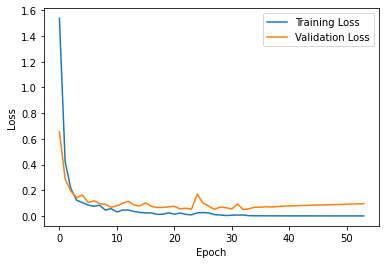

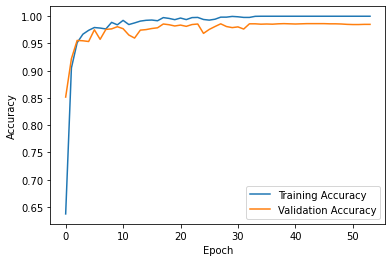

426/426 [==============================] - 1s 3ms/step - loss: 0.2081 - accuracy: 0.9546 - mse: 110.4894
Average accuracy: 0.9535328269004821/n Average MSE: 0.9535328269004821/n Accuracy by model: [0.9465480446815491, 0.9480920433998108, 0.9601500034332275, 0.9582383632659912, 0.9546356797218323]


In [ ]:
all_sensors = fit_models()
all_sensors.run_lstm(5)

## Other subsets

X_train: (6040, 50, 9), X_test: (13601, 50, 9), y_train: (6040, 1), y_test: (13601, 1)
Taining model number: 0


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-ra/model_0/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-ra/model_0/assets


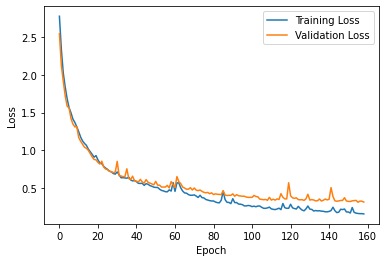

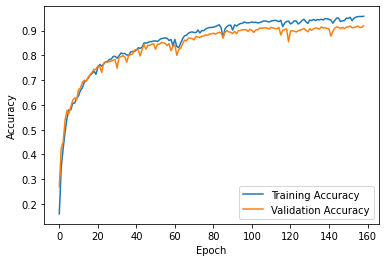

426/426 [==============================] - 1s 3ms/step - loss: 0.8270 - accuracy: 0.8407 - mse: 110.4817
Taining model number: 1


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-ra/model_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-ra/model_1/assets


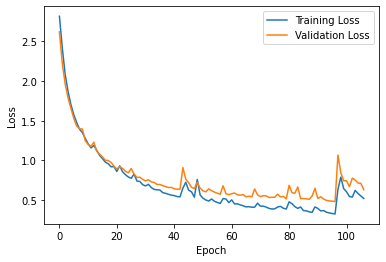

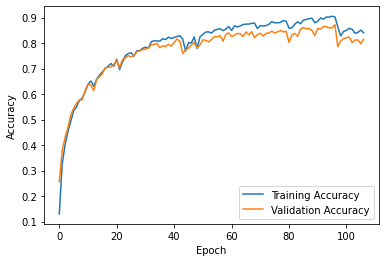

426/426 [==============================] - 1s 3ms/step - loss: 0.9184 - accuracy: 0.7968 - mse: 110.4774
Taining model number: 2


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-ra/model_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-ra/model_2/assets


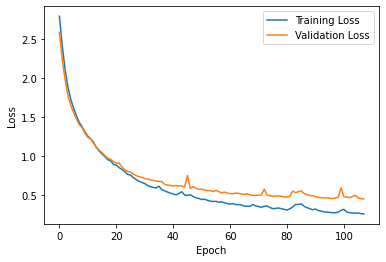

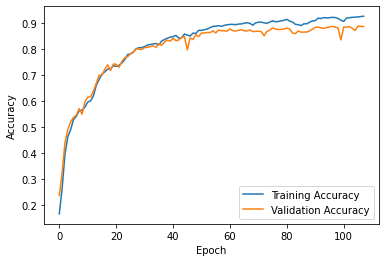

426/426 [==============================] - 1s 3ms/step - loss: 0.9103 - accuracy: 0.8157 - mse: 110.4794
Average accuracy: 0.8177339831988016/n Average MSE: 0.8177339831988016/n Accuracy by model: [0.8407469987869263, 0.7967796325683594, 0.8156753182411194]


In [ ]:
right_arm = fit_models('ra')
right_arm.run_lstm(3)

X_train: (6040, 50, 9), X_test: (13601, 50, 9), y_train: (6040, 1), y_test: (13601, 1)
Training model number: 0


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-la/model_0/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-la/model_0/assets


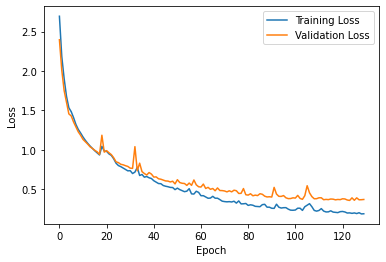

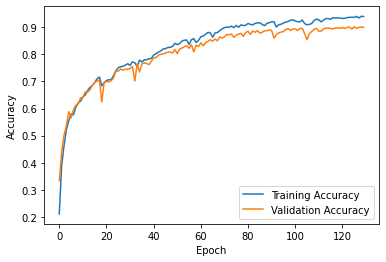

426/426 [==============================] - 1s 3ms/step - loss: 0.7205 - accuracy: 0.8315 - mse: 110.4820
Training model number: 1


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-la/model_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-la/model_1/assets


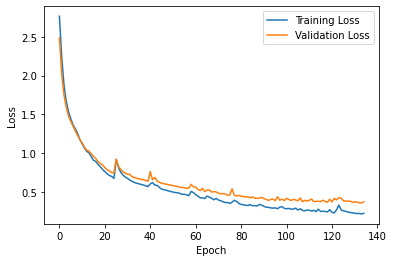

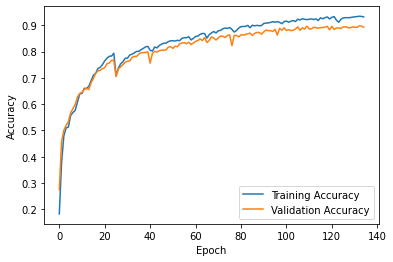

426/426 [==============================] - 1s 3ms/step - loss: 0.5986 - accuracy: 0.8532 - mse: 110.4813
Training model number: 2


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-la/model_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-la/model_2/assets


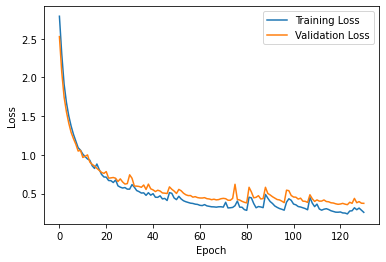

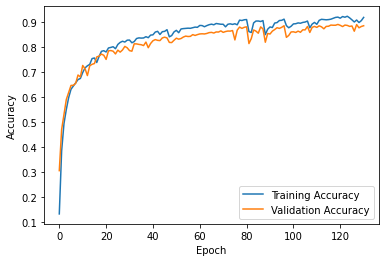

426/426 [==============================] - 1s 3ms/step - loss: 0.7757 - accuracy: 0.8357 - mse: 110.4811
Average accuracy: 0.8401343027750651/n Average MSE: 0.8401343027750651/n Accuracy by model: [0.831483006477356, 0.8531725406646729, 0.8357473611831665]


In [ ]:
left_arm = fit_models('la')
left_arm.run_lstm(3)

X_train: (6040, 50, 15), X_test: (13601, 50, 15), y_train: (6040, 1), y_test: (13601, 1)
Training model number: 0


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-acc/model_0/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-acc/model_0/assets


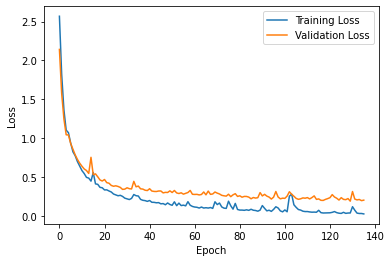

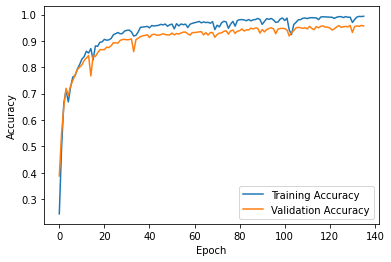

426/426 [==============================] - 1s 3ms/step - loss: 0.4360 - accuracy: 0.9051 - mse: 110.4871
Training model number: 1


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-acc/model_1/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-acc/model_1/assets


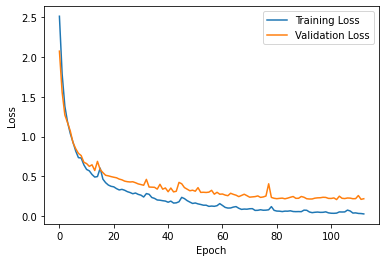

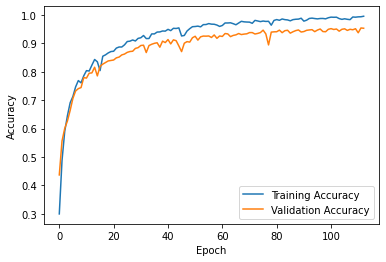

426/426 [==============================] - 1s 3ms/step - loss: 0.5633 - accuracy: 0.8861 - mse: 110.4868
Training model number: 2


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-acc/model_2/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/activity-classification/my-data/models/lstm-acc/model_2/assets


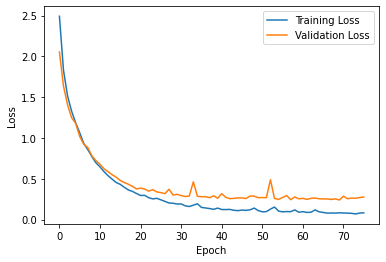

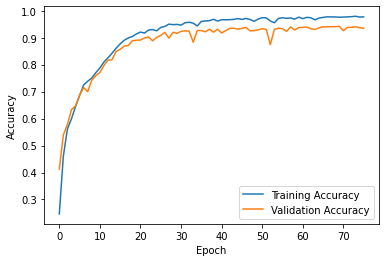

426/426 [==============================] - 1s 3ms/step - loss: 0.4250 - accuracy: 0.8980 - mse: 110.4857
Average accuracy: 0.8964046637217203/n Average MSE: 0.8964046637217203/n Accuracy by model: [0.9050804972648621, 0.886111319065094, 0.8980221748352051]


In [ ]:
accelerometer = fit_models('acc')
accelerometer.run_lstm(3)

## Right arm accelerometer

In [ ]:
right_arm_accelerometer = fit_models('ra_.acc')
right_arm_accelerometer.run_lstm(5)

In [ ]:
predictions = right_arm_accelerometer.lstm.predict_classes(right_arm_accelerometer.X_test_window)
pred_matrix = confusion_matrix(y_true=right_arm_accelerometer.y_test_window, y_pred=predictions).astype('int')
sns.heatmap(pred_matrix, cmap='YlGnBu')

In [ ]:
# load model
load_test = tf.keras.models.load_model(str(path + '/my-data/models/lstm-ra_.acc'))

In [ ]:
load_test.summary()

# Random forest classifier